### Libraries

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

### Imbalanced data

In [81]:
# Read in data

t0 = time.time()
df = pd.read_csv('aggregate-20160501.csv')
t1 = time.time()
print(str((t1-t0)/60) + " minutes")

2.264633576075236 minutes


In [3]:
#df.head()
#df.shape
#df.columns
#set(df.num_edits)

In [4]:
# Calculate percentage of unedited articles in original imbalanced data

len(df["num_edits"][df["num_edits"] == 0])/len(df["num_edits"])*100

99.91720181519122

In [5]:
# Check missingness in original imbalanced data

print(df.isnull().sum())

article_name                   1
num_edits                      0
views_30d                      0
views_7d                       0
views_3d                       0
views_1d                       0
edits_30d                      0
edits_7d                       0
edits_3d                       0
edits_1d                       0
minor_edits_30d                0
minor_edits_7d                 0
minor_edits_3d                 0
minor_edits_1d                 0
avg_size_30d             6428583
avg_size_7d             45268487
avg_size_3d             49800824
avg_size_1d             53028939
avg_size                  209968
latest_size               209968
talk_views_30d                 0
talk_views_7d                  0
talk_views_3d                  0
talk_views_1d                  0
talk_edits_30d                 0
talk_edits_7d                  0
talk_edits_3d                  0
talk_edits_1d                  0
talk_minor_edits_30d           0
talk_minor_edits_7d            0
talk_minor

In [6]:
# Generate binary edited vs. unedited variable

df['num_edits_binary'] = df['num_edits'].apply(lambda x: int(x > 0))
#set(df['num_edits_binary'])

In [7]:
# Store relevant variable names in a list

feature_names = [x for x in df.columns if 'num_edits' not in x and 'article_name' not in x]

label_name = "num_edits_binary"

feature_names

['views_30d',
 'views_7d',
 'views_3d',
 'views_1d',
 'edits_30d',
 'edits_7d',
 'edits_3d',
 'edits_1d',
 'minor_edits_30d',
 'minor_edits_7d',
 'minor_edits_3d',
 'minor_edits_1d',
 'avg_size_30d',
 'avg_size_7d',
 'avg_size_3d',
 'avg_size_1d',
 'avg_size',
 'latest_size',
 'talk_views_30d',
 'talk_views_7d',
 'talk_views_3d',
 'talk_views_1d',
 'talk_edits_30d',
 'talk_edits_7d',
 'talk_edits_3d',
 'talk_edits_1d',
 'talk_minor_edits_30d',
 'talk_minor_edits_7d',
 'talk_minor_edits_3d',
 'talk_minor_edits_1d',
 'talk_avg_size_30d',
 'talk_avg_size_7d',
 'talk_avg_size_3d',
 'talk_avg_size_1d',
 'talk_avg_size',
 'talk_latest_size']

### Balanced data

In [8]:
## Generate balanced sample

t0 = time.time()

np.random.seed(seed=13579)

# to be set aside as imbalanced test data
set1_idx = np.random.choice(range(len(df)), int(len(df) * .2), replace=False)
set1_X = df.loc[set1_idx, feature_names]
set1_Y = df.loc[set1_idx, label_name]

# to be used to generate balanced data for main analysis
set2_idx = list(set(range(len(df))) - set(list(set1_idx)))
set2 = df.loc[set2_idx, list(df.columns.tolist())]

edited = set2[set2.num_edits > 0.0].copy(deep=True)
#edited.shape

not_edited = set2[set2.num_edits == 0.0].copy(deep=True)

not_edited_selected = not_edited[0:edited.shape[0]]

balanced_set = pd.concat([edited, not_edited_selected])

balanced_set = shuffle(balanced_set)
#balanced_set.shape

t1 = time.time()
print(str((t1-t0)/60) + " minutes")

4.955658749739329 minutes


In [9]:
print(edited.shape)
print(balanced_set.shape)

(41624, 39)
(83248, 39)


In [10]:
# Write balanced data to csv

balanced_set.to_csv('balanced_set_20160501.csv', sep=',')
#balanced_set.head()

In [2]:
# Read in balanced data

df_b = pd.read_csv('balanced_set_20160501.csv')
df_b = df_b.set_index('Unnamed: 0')
df_b.index.name = None
#df_b.head()

In [3]:
# Calculate percentage of unedited articles in balanced data

len(df_b["num_edits_binary"][df_b["num_edits_binary"] == 0])/len(df_b["num_edits_binary"])*100

50.0

In [4]:
# Check missingness in balanced data

print(df_b.isnull().sum())

article_name                0
num_edits                   0
views_30d                   0
views_7d                    0
views_3d                    0
views_1d                    0
edits_30d                   0
edits_7d                    0
edits_3d                    0
edits_1d                    0
minor_edits_30d             0
minor_edits_7d              0
minor_edits_3d              0
minor_edits_1d              0
avg_size_30d              496
avg_size_7d              7505
avg_size_3d              9725
avg_size_1d             10885
avg_size                    1
latest_size                 1
talk_views_30d              0
talk_views_7d               0
talk_views_3d               0
talk_views_1d               0
talk_edits_30d              0
talk_edits_7d               0
talk_edits_3d               0
talk_edits_1d               0
talk_minor_edits_30d        0
talk_minor_edits_7d         0
talk_minor_edits_3d         0
talk_minor_edits_1d         0
talk_avg_size_30d       17892
talk_avg_s

### New Features

In [5]:
# Generate features

# Views

df_b['total_views'] = df_b.views_1d + df_b.views_3d + df_b.views_7d + df_b.views_30d

# Version 1

df_b['change_in_views_v1_7_30'] = df_b.views_7d/4 - df_b.views_30d/23

df_b['change_in_views_v1_3_7'] = df_b.views_3d/2 - df_b.views_7d/4 

df_b['change_in_views_v1_1_3'] = df_b.views_1d/1 - df_b.views_3d/2

# Version 2

df_b['change_in_views_v2_7_30'] = ((df_b.views_7d/4)+1)/((df_b.views_30d/23)+1)

df_b['change_in_views_v2_3_7'] = ((df_b.views_3d/2)+1)/((df_b.views_7d/4)+1)

df_b['change_in_views_v2_1_3'] = ((df_b.views_1d/1)+1)/((df_b.views_3d/2)+1)

#df_b['total_views'].describe()

In [6]:
# Edits

df_b['total_edits'] = df_b.edits_1d + df_b.edits_3d + df_b.edits_7d + df_b.edits_30d

# Version 1

df_b['change_in_edits_v1_7_30'] = df_b.edits_7d/4 - df_b.edits_30d/23

df_b['change_in_edits_v1_3_7'] = df_b.edits_3d/2 - df_b.edits_7d/4

df_b['change_in_edits_v1_1_3'] = df_b.edits_1d/1 - df_b.edits_3d/2

# Version 2

df_b['change_in_edits_v2_7_30'] = ((df_b.edits_7d/4)+1)/((df_b.edits_30d/23)+1)

df_b['change_in_edits_v2_3_7'] = ((df_b.edits_3d/2)+1)/((df_b.edits_7d/4)+1)

df_b['change_in_edits_v2_1_3'] = ((df_b.edits_1d/1)+1)/((df_b.edits_3d/2)+1)

#df_b['total_edits'].describe()

In [7]:
# Minor edits

df_b['total_minor_edits'] = df_b.minor_edits_1d + df_b.minor_edits_3d + df_b.minor_edits_7d + df_b.minor_edits_30d

# Version 1

df_b['change_in_minor_edits_v1_7_30'] = df_b.minor_edits_7d/4 - df_b.minor_edits_30d/23

df_b['change_in_minor_edits_v1_3_7'] = df_b.minor_edits_3d/2 - df_b.minor_edits_7d/4

df_b['change_in_minor_edits_v1_1_3'] = df_b.minor_edits_1d/1 - df_b.minor_edits_3d/2

# Version 2

df_b['change_in_minor_edits_v2_7_30'] = ((df_b.minor_edits_7d/4)+1)/((df_b.minor_edits_30d/23)+1)

df_b['change_in_minor_edits_v2_3_7'] = ((df_b.minor_edits_3d/2)+1)/((df_b.minor_edits_7d/4)+1)

df_b['change_in_minor_edits_v2_1_3'] = ((df_b.minor_edits_1d/1)+1)/((df_b.minor_edits_3d/2)+1)

#df_b['total_minor_edits'].describe()

In [8]:
# Average size

# Version 1

df_b['change_in_avg_size_v1_7_30'] = df_b[['avg_size_7d', 'avg_size_30d', 'edits_7d', 'edits_30d']].apply(
    lambda x: 0
    if (x['edits_7d'] + x['edits_30d'] == 0)
    else (x['avg_size_7d']/4 - x['avg_size_30d']/23), 
    axis=1
)

df_b['change_in_avg_size_v1_3_7'] = df_b[['avg_size_3d', 'avg_size_7d', 'edits_3d', 'edits_7d']].apply(
    lambda x: 0
    if (x['edits_3d'] + x['edits_7d'] == 0)
    else (x['avg_size_3d']/2 - x['avg_size_7d']/4), 
    axis=1
)

df_b['change_in_avg_size_v1_1_3'] = df_b[['avg_size_1d', 'avg_size_3d', 'edits_1d', 'edits_3d']].apply(
    lambda x: 0
    if (x['edits_1d'] + x['edits_3d'] == 0)
    else (x['avg_size_1d']/1 - x['avg_size_3d']/2), 
    axis=1
)

# Version 2

df_b['change_in_avg_size_v2_7_30'] = df_b[['avg_size_7d', 'avg_size_30d', 'edits_7d', 'edits_30d']].apply(
    lambda x: 0
    if (x['edits_7d'] + x['edits_30d'] == 0)
    else (((x['avg_size_7d']/4)+1)/((x['avg_size_30d']/23)+1)), 
    axis=1
)

df_b['change_in_avg_size_v2_3_7'] = df_b[['avg_size_3d', 'avg_size_7d', 'edits_3d', 'edits_7d']].apply(
    lambda x: 0
    if (x['edits_3d'] + x['edits_7d'] == 0)
    else (((x['avg_size_3d']/2)+1)/((x['avg_size_7d']/4)+1)), 
    axis=1
)

df_b['change_in_avg_size_v2_1_3'] = df_b[['avg_size_1d', 'avg_size_3d', 'edits_1d', 'edits_3d']].apply(
    lambda x: 0
    if (x['edits_1d'] + x['edits_3d'] == 0)
    else (((x['avg_size_1d']/1)+1)/((x['avg_size_3d']/2)+1)), 
    axis=1
)

#df_b['change_in_avg_size_v2_1_3'].describe()

In [9]:
# Talk views

df_b['total_talk_views'] = df_b.talk_views_1d + df_b.talk_views_3d + df_b.talk_views_7d + df_b.talk_views_30d

# Version 1

df_b['change_in_talk_views_v1_7_30'] = df_b.talk_views_7d/4 - df_b.talk_views_30d/23

df_b['change_in_talk_views_v1_3_7'] = df_b.talk_views_3d/2 - df_b.talk_views_7d/4 

df_b['change_in_talk_views_v1_1_3'] = df_b.talk_views_1d/1 - df_b.talk_views_3d/2

# Version 2

df_b['change_in_talk_views_v2_7_30'] = ((df_b.talk_views_7d/4)+1)/((df_b.talk_views_30d/23)+1)

df_b['change_in_talk_views_v2_3_7'] = ((df_b.talk_views_3d/2)+1)/((df_b.talk_views_7d/4)+1)

df_b['change_in_talk_views_v2_1_3'] = ((df_b.talk_views_1d/1)+1)/((df_b.talk_views_3d/2)+1)

#df_b['total_talk_views'].describe()

In [10]:
# Talk edits

df_b['total_talk_edits'] = df_b.talk_edits_1d + df_b.talk_edits_3d + df_b.talk_edits_7d + df_b.talk_edits_30d

# Version 1

df_b['change_in_talk_edits_v1_7_30'] = df_b.talk_edits_7d/4 - df_b.talk_edits_30d/23

df_b['change_in_talk_edits_v1_3_7'] = df_b.talk_edits_3d/2 - df_b.talk_edits_7d/4

df_b['change_in_talk_edits_v1_1_3'] = df_b.talk_edits_1d/1 - df_b.talk_edits_3d/2

# Version 2

df_b['change_in_talk_edits_v2_7_30'] = ((df_b.talk_edits_7d/4)+1)/((df_b.talk_edits_30d/23)+1)

df_b['change_in_talk_edits_v2_3_7'] = ((df_b.talk_edits_3d/2)+1)/((df_b.talk_edits_7d/4)+1)

df_b['change_in_talk_edits_v2_1_3'] = ((df_b.talk_edits_1d/1)+1)/((df_b.talk_edits_3d/2)+1)

#df_b['total_talk_edits'].describe()

In [11]:
# Talk minor edits

df_b['total_talk_minor_edits'] = (df_b.talk_minor_edits_1d + df_b.talk_minor_edits_3d + 
                                  df_b.talk_minor_edits_7d + df_b.talk_minor_edits_30d)


# Version 1

df_b['change_in_talk_minor_edits_v1_7_30'] = df_b.talk_minor_edits_7d/4 - df_b.talk_minor_edits_30d/23

df_b['change_in_talk_minor_edits_v1_3_7'] = df_b.talk_minor_edits_3d/2 - df_b.talk_minor_edits_7d/4

df_b['change_in_talk_minor_edits_v1_1_3'] = df_b.talk_minor_edits_1d/1 - df_b.talk_minor_edits_3d/2

# Version 2

df_b['change_in_talk_minor_edits_v2_7_30'] = ((df_b.talk_minor_edits_7d/4)+1)/((df_b.talk_minor_edits_30d/23)+1)

df_b['change_in_talk_minor_edits_v2_3_7'] = ((df_b.talk_minor_edits_3d/2)+1)/((df_b.talk_minor_edits_7d/4)+1)

df_b['change_in_talk_minor_edits_v2_1_3'] = ((df_b.talk_minor_edits_1d/1)+1)/((df_b.talk_minor_edits_3d/2)+1)

#df_b['total_talk_minor_edits'].describe()

In [12]:
# Talk average size

# Version 1

df_b['change_in_talk_avg_size_v1_7_30'] = df_b[['talk_avg_size_7d', 'talk_avg_size_30d', 
                                                'talk_edits_7d', 'talk_edits_30d']].apply(
    lambda x: 0
    if (x['talk_edits_7d'] + x['talk_edits_30d'] == 0)
    else (x['talk_avg_size_7d']/4 - x['talk_avg_size_30d']/23), 
    axis=1
)

df_b['change_in_talk_avg_size_v1_3_7'] = df_b[['talk_avg_size_3d', 'talk_avg_size_7d', 
                                               'talk_edits_3d', 'talk_edits_7d']].apply(
    lambda x: 0
    if (x['talk_edits_3d'] + x['talk_edits_7d'] == 0)
    else (x['talk_avg_size_3d']/2 - x['talk_avg_size_7d']/4), 
    axis=1
)

df_b['change_in_talk_avg_size_v1_1_3'] = df_b[['talk_avg_size_1d', 'talk_avg_size_3d', 
                                               'talk_edits_1d', 'talk_edits_3d']].apply(
    lambda x: 0
    if (x['talk_edits_1d'] + x['talk_edits_3d'] == 0)
    else (x['talk_avg_size_1d']/1 - x['talk_avg_size_3d']/2), 
    axis=1
)

# Version 2

df_b['change_in_talk_avg_size_v2_7_30'] = df_b[['talk_avg_size_7d', 'talk_avg_size_30d', 
                                                'talk_edits_7d', 'talk_edits_30d']].apply(
    lambda x: 0
    if (x['talk_edits_7d'] + x['talk_edits_30d'] == 0)
    else (((x['talk_avg_size_7d']/4)+1)/((x['talk_avg_size_30d']/23)+1)), 
    axis=1
)

df_b['change_in_talk_avg_size_v2_3_7'] = df_b[['talk_avg_size_3d', 'talk_avg_size_7d', 
                                               'talk_edits_3d', 'talk_edits_7d']].apply(
    lambda x: 0
    if (x['talk_edits_3d'] + x['talk_edits_7d'] == 0)
    else (((x['talk_avg_size_3d']/2)+1)/((x['talk_avg_size_7d']/4)+1)), 
    axis=1
)

df_b['change_in_talk_avg_size_v2_1_3'] = df_b[['talk_avg_size_1d', 'talk_avg_size_3d', 
                                               'talk_edits_1d', 'talk_edits_3d']].apply(
    lambda x: 0
    if (x['talk_edits_1d'] + x['talk_edits_3d'] == 0)
    else (((x['talk_avg_size_1d']/1)+1)/((x['talk_avg_size_3d']/2)+1)), 
    axis=1
)

#df_b['change_in_talk_avg_size_v2_1_3'].describe()

In [13]:
# Check missingness in balanced data with new features

print(df_b.isnull().sum())

article_name                              0
num_edits                                 0
views_30d                                 0
views_7d                                  0
views_3d                                  0
views_1d                                  0
edits_30d                                 0
edits_7d                                  0
edits_3d                                  0
edits_1d                                  0
minor_edits_30d                           0
minor_edits_7d                            0
minor_edits_3d                            0
minor_edits_1d                            0
avg_size_30d                            496
avg_size_7d                            7505
avg_size_3d                            9725
avg_size_1d                           10885
avg_size                                  1
latest_size                               1
talk_views_30d                            0
talk_views_7d                             0
talk_views_3d                   

In [14]:
# Write balanced data (with new features) to csv

df_b.to_csv('balanced_set2_20160501.csv', sep=',')
#df_b.head()

In [82]:
# Read in balanced data (with new features)

df_b2 = pd.read_csv('balanced_set2_20160501.csv')
df_b2 = df_b2.set_index('Unnamed: 0')
df_b2.index.name = None
print(df_b2.shape)
#df_b2.head()

(83248, 93)


In [91]:
df_b2_reset_index = df_b2.reset_index()
df_b2_reset_index = df_b2_reset_index.rename(columns={'index': 'original_index'})
df_b2_reset_index.shape
#df_b2_ri.head()

(83248, 94)

In [92]:
# Store relevant variable names (including new features) in a list

new_feature_names = [x for x in df_b2_ri.columns 
                     if 'original_index' not in x
                     and 'article_name' not in x
                     and 'num_edits' not in x
                     and 'views_30d' not in x
                     and 'views_7d' not in x
                     and 'views_3d' not in x
                     and 'views_1d' not in x
                     and 'edits_30d' not in x
                     and 'edits_7d' not in x
                     and 'edits_3d' not in x
                     and 'edits_1d' not in x
                     and 'minor_edits_30d' not in x
                     and 'minor_edits_7d' not in x
                     and 'minor_edits_3d' not in x
                     and 'minor_edits_1d' not in x
                     and 'avg_size_30d' not in x
                     and 'avg_size_7d' not in x
                     and 'avg_size_3d' not in x
                     and 'avg_size_1d' not in x
                     and 'talk_views_30d' not in x
                     and 'talk_views_7d' not in x
                     and 'talk_views_3d' not in x
                     and 'talk_views_1d' not in x
                     and 'talk_edits_30d' not in x
                     and 'talk_edits_7d' not in x
                     and 'talk_edits_3d' not in x
                     and 'talk_edits_1d' not in x
                     and 'talk_minor_edits_30d' not in x
                     and 'talk_minor_edits_7d' not in x
                     and 'talk_minor_edits_3d' not in x
                     and 'talk_minor_edits_1d' not in x
                     and 'talk_avg_size_30d' not in x
                     and 'talk_avg_size_7d' not in x
                     and 'talk_avg_size_3d' not in x
                     and 'talk_avg_size_1d' not in x
                     and 'talk_avg_size' not in x
                     and 'talk_latest_size' not in x]

print(len(new_feature_names))

label_name = "num_edits_binary"

50


In [125]:
# Drop rows with NaN's 

df_b2_ri = df_b2_reset_index[new_feature_names + [label_name]]
df_b2_ri = df_b2_ri.dropna() 

df_b2_ri = df_b2_ri.reset_index()
df_b2_ri = df_b2_ri.drop('index', 1)

print(df_b2_ri.shape)

(82461, 51)


In [7]:
df_b2_ri.isnull().sum()

avg_size                              0
latest_size                           0
total_views                           0
change_in_views_v1_7_30               0
change_in_views_v1_3_7                0
change_in_views_v1_1_3                0
change_in_views_v2_7_30               0
change_in_views_v2_3_7                0
change_in_views_v2_1_3                0
total_edits                           0
change_in_edits_v1_7_30               0
change_in_edits_v1_3_7                0
change_in_edits_v1_1_3                0
change_in_edits_v2_7_30               0
change_in_edits_v2_3_7                0
change_in_edits_v2_1_3                0
total_minor_edits                     0
change_in_minor_edits_v1_7_30         0
change_in_minor_edits_v1_3_7          0
change_in_minor_edits_v1_1_3          0
change_in_minor_edits_v2_7_30         0
change_in_minor_edits_v2_3_7          0
change_in_minor_edits_v2_1_3          0
change_in_avg_size_v1_7_30            0
change_in_avg_size_v1_3_7             0


In [8]:
print(len(df_b2_ri[df_b2_ri.num_edits_binary == 0])) # number of unedited articles
print(len(df_b2_ri[df_b2_ri.num_edits_binary != 0])) # number of edited articles

41613
40848


In [8]:
# Normalize features

def normalize(raw_data):
    mean = np.mean(raw_data)
    sd = np.std(raw_data)
    normalized_data = (raw_data-mean)/sd
    return normalized_data

In [9]:
features = list(set(df_b2_ri.columns.tolist()) - set(['num_edits_binary']))

df_b2_ri_n = df_b2_ri.copy(deep=True)

for f in features:
    df_b2_ri_n[f] = normalize(df_b2_ri_n[f])
    
#df_b2_ri_n.head()

In [10]:
# Convert data frame to matrix

X = df_b2_ri_n[new_feature_names].as_matrix()
X_nn = df_b2_ri[new_feature_names].as_matrix()

Y = df_b2_ri_n[label_name].as_matrix()
Y_nn = df_b2_ri[label_name].as_matrix()

### Correlation matrix

In [11]:
corr_table = df_b2_ri_n[[label_name] + new_feature_names].corr(method='pearson')
corr_table.style.background_gradient(cmap='RdYlGn', axis = 0)

### Models

In [13]:
# Logistic regression

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

logit_test_acc = []
logit_test_precision = []
logit_test_recall = []
logit_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    logit = LogisticRegression()
    logit.fit(train_x, train_y)
    
    y_pred_test = logit.predict(test_x)
    
    logit_test_acc += [accuracy_score(test_y, y_pred_test)]
    logit_test_precision += [precision_score(test_y, y_pred_test)]
    logit_test_recall += [recall_score(test_y, y_pred_test)]
    logit_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
logit_time_taken = t1-t0

print("Time taken is: " + str(logit_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(logit_test_acc)))
print("Test precision is: " + str(np.mean(logit_test_precision)))
print("Test recall is: " + str(np.mean(logit_test_recall)))
print("Test ROC AUC is: " + str(np.mean(logit_test_roc_auc)))

Time taken is: 1.2720117052396138 minutes
Test accuracy is: 0.680673302938
Test precision is: 0.774031409637
Test recall is: 0.501929920901
Test ROC AUC is: 0.679040359935


In [14]:
# Decision tree

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

tree_test_acc = []
tree_test_precision = []
tree_test_recall = []
tree_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    tree = DecisionTreeClassifier(random_state=13579, max_depth=18)
    tree.fit(train_x, train_y)
    
    y_pred_test = tree.predict(test_x)
    
    tree_test_acc += [accuracy_score(test_y, y_pred_test)]
    tree_test_precision += [precision_score(test_y, y_pred_test)]
    tree_test_recall += [recall_score(test_y, y_pred_test)]
    tree_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
tree_time_taken = t1-t0

print("Time taken is: " + str(tree_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(tree_test_acc)))
print("Test precision is: " + str(np.mean(tree_test_precision)))
print("Test recall is: " + str(np.mean(tree_test_recall)))
print("Test ROC AUC is: " + str(np.mean(tree_test_roc_auc)))

Time taken is: 0.16822611093521117 minutes
Test accuracy is: 0.740689482344
Test precision is: 0.743336302184
Test recall is: 0.727995844656
Test ROC AUC is: 0.740600934479


In [15]:
# LASSO

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

lasso_test_acc = []
lasso_test_precision = []
lasso_test_recall = []
lasso_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    lasso = LogisticRegression(penalty = 'l1')
    lasso.fit(train_x, train_y)
    
    y_pred_test = lasso.predict(test_x)
    
    lasso_test_acc += [accuracy_score(test_y, y_pred_test)]
    lasso_test_precision += [precision_score(test_y, y_pred_test)]
    lasso_test_recall += [recall_score(test_y, y_pred_test)]
    lasso_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
lasso_time_taken = t1-t0

print("Time taken is: " + str(lasso_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(lasso_test_acc)))
print("Test precision is: " + str(np.mean(lasso_test_precision)))
print("Test recall is: " + str(np.mean(lasso_test_recall)))
print("Test ROC AUC is: " + str(np.mean(lasso_test_roc_auc)))

Time taken is: 1.453496015071869 minutes
Test accuracy is: 0.657195577236
Test precision is: 0.792982644544
Test recall is: 0.417804621667
Test ROC AUC is: 0.654824921656


In [16]:
# K-nearest neighbors

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

knn_test_acc = []
knn_test_precision = []
knn_test_recall = []
knn_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    
    knn = KNeighborsClassifier()
    knn.fit(train_x, train_y)
    
    y_pred_test = knn.predict(test_x)
    
    knn_test_acc += [accuracy_score(test_y, y_pred_test)]
    knn_test_precision += [precision_score(test_y, y_pred_test)]
    knn_test_recall += [recall_score(test_y, y_pred_test)]
    knn_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
knn_time_taken = t1-t0
    
print("Time taken is: " + str(knn_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(knn_test_acc)))
print("Test precision is: " + str(np.mean(knn_test_precision)))
print("Test recall is: " + str(np.mean(knn_test_recall)))
print("Test ROC AUC is: " + str(np.mean(knn_test_roc_auc)))

Time taken is: 5.8344937562942505 minutes
Test accuracy is: 0.680454999107
Test precision is: 0.685862821336
Test recall is: 0.654834635854
Test ROC AUC is: 0.680217249777


In [17]:
# Random forest

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

forest_test_acc = []
forest_test_precision = []
forest_test_recall = []
forest_test_roc_auc = []



t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    forest = RandomForestClassifier(random_state=13579, max_depth=18)
    forest.fit(train_x, train_y)
    
    y_pred_test = forest.predict(test_x)

    
    forest_test_acc += [accuracy_score(test_y, y_pred_test)]
    forest_test_precision += [precision_score(test_y, y_pred_test)]
    forest_test_recall += [recall_score(test_y, y_pred_test)]
    forest_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

    
t1 = time.time()
forest_time_taken = t1-t0

print("Time taken is: " + str(forest_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(forest_test_acc)))
print("Test precision is: " + str(np.mean(forest_test_precision)))
print("Test recall is: " + str(np.mean(forest_test_recall)))
print("Test ROC AUC is: " + str(np.mean(forest_test_roc_auc)))

Time taken is: 0.16986701488494874 minutes
Test accuracy is: 0.77916834208
Test precision is: 0.780619675578
Test recall is: 0.770834443973
Test ROC AUC is: 0.779094241499


In [18]:
# Multi-layer perceptron

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

tron_test_acc = []
tron_test_precision = []
tron_test_recall = []
tron_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    tron = MLPClassifier(solver='lbfgs', random_state=13579)
    tron.fit(train_x, train_y)
    
    y_pred_test = tron.predict(test_x)
    
    tron_test_acc += [accuracy_score(test_y, y_pred_test)]
    tron_test_precision += [precision_score(test_y, y_pred_test)]
    tron_test_recall += [recall_score(test_y, y_pred_test)]
    tron_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
tron_time_taken = t1-t0

print("Time taken is: " + str(tron_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(tron_test_acc)))
print("Test precision is: " + str(np.mean(tron_test_precision)))
print("Test recall is: " + str(np.mean(tron_test_recall)))
print("Test ROC AUC is: " + str(np.mean(tron_test_roc_auc)))

Time taken is: 6.402426640192668 minutes
Test accuracy is: 0.759352861375
Test precision is: 0.771455909475
Test recall is: 0.730765222254
Test ROC AUC is: 0.759130873665


In [27]:
# Gradient boosting

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

boost_test_acc = []
boost_test_precision = []
boost_test_recall = []
boost_test_roc_auc = []
tn_fp_fn_tp = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    

    boost = GradientBoostingClassifier(random_state=13579, max_depth=7)
    boost.fit(train_x, train_y)
    
    y_pred_test = boost.predict(test_x)
    
    boost_test_acc += [accuracy_score(test_y, y_pred_test)]
    boost_test_precision += [precision_score(test_y, y_pred_test)]
    boost_test_recall += [recall_score(test_y, y_pred_test)]
    boost_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    tn_fp_fn_tp.append(confusion_matrix(test_y, y_pred_test).ravel())



t1 = time.time()
boost_time_taken = t1-t0

confusion_string = (np.sum(tn_fp_fn_tp, axis=0))

print("Time taken is: " + str(boost_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(boost_test_acc)))
print("Test precision is: " + str(np.mean(boost_test_precision)))
print("Test recall is: " + str(np.mean(boost_test_recall)))
print("Test ROC AUC is: " + str(np.mean(boost_test_roc_auc)))
print("TN, FP, FN, TP: " + str(confusion_string))

Time taken is: 5.223333175977071 minutes
Test accuracy is: 0.796570491786
Test precision is: 0.79392525809
Test recall is: 0.795945662604
Test ROC AUC is: 0.796575643603
TN, FP, FN, TP: [33174  8439  8336 32512]


In [32]:
# Ensemble learner

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

logit = LogisticRegression()
tree = DecisionTreeClassifier(random_state=13579, max_depth = 18)
lasso = LogisticRegression(penalty = 'l1')
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state=13579, max_depth = 18)
tron = MLPClassifier(solver='lbfgs', random_state=13579)
boost = GradientBoostingClassifier(random_state=13579, max_depth=7)

mv_model = VotingClassifier([('logit', logit), 
                             ('tree', tree), 
                             ('lasso', lasso),
                             ('knn', knn),
                             ('forest', forest),
                             ('tron', tron),
                             ('boost', boost)], voting='soft')

mv_model_test_acc = []
mv_model_test_precision = []
mv_model_test_recall = []
mv_model_test_roc_auc = []


t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    
    mv_model.fit(train_x, train_y)
    
    y_pred_test = mv_model.predict(test_x)
    
    mv_model_test_acc += [accuracy_score(test_y, y_pred_test)]
    mv_model_test_precision += [precision_score(test_y, y_pred_test)]
    mv_model_test_recall += [recall_score(test_y, y_pred_test)]
    mv_model_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

    
t1 = time.time()
mv_model_time_taken = t1-t0
    


print("Time taken is: " + str(mv_model_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(mv_model_test_acc)))
print("Test precision is: " + str(np.mean(mv_model_test_precision)))
print("Test recall is: " + str(np.mean(mv_model_test_recall)))
print("Test ROC AUC is: " + str(np.mean(mv_model_test_roc_auc)))


Time taken is: 16.045209980010988 minutes
Test accuracy is: 0.782212168624
Test precision is: 0.798681793385
Test recall is: 0.749298254583
Test ROC AUC is: 0.781941103805
TN, FP, FN, TP: [33174  8439  8336 32512]


In [30]:
def plot_precision_recall(test_precisions, test_recalls, accuracy, roc_auc, names):
    ind = np.arange(7)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, test_precisions, width, color='r')
    rects2 = ax.bar(ind + width, test_recalls, width, color='y')
    ax.set_ylabel('Scores')
    ax.set_title('Test set: precision and recall per classifier')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.legend((rects1[0], rects2[0]), ('precision', 'recall'), loc='lower right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    fig, ax = plt.subplots()
    rects3 = ax.bar(ind, accuracy, width, color='r')
    rects4 = ax.bar(ind + width, roc_auc, width, color='y')
    ax.set_ylabel('Scores')
    ax.set_title('Test set: accuracy and ROC AUC per classifier')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.legend((rects1[0], rects2[0]), ('accuracy', 'roc auc'), loc='lower right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()


Precisions and recalls for single models


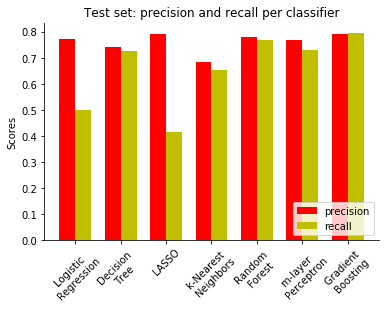

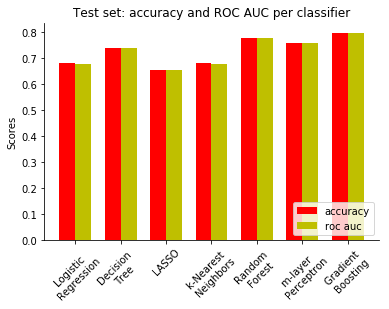

In [31]:
test_precisions = [np.mean(logit_test_precision), np.mean(tree_test_precision),
                   np.mean(lasso_test_precision), np.mean(knn_test_precision),
                   np.mean(forest_test_precision), np.mean(tron_test_precision),
                   np.mean(boost_test_precision)]

test_recalls = [np.mean(logit_test_recall), np.mean(tree_test_recall),
                   np.mean(lasso_test_recall), np.mean(knn_test_recall),
                   np.mean(forest_test_recall), np.mean(tron_test_recall),
                   np.mean(boost_test_recall)]

accuracy = [np.mean(logit_test_acc), np.mean(tree_test_acc),
                   np.mean(lasso_test_acc), np.mean(knn_test_acc),
                   np.mean(forest_test_acc), np.mean(tron_test_acc),
                   np.mean(boost_test_acc)]


roc_auc = [np.mean(logit_test_roc_auc), np.mean(tree_test_roc_auc),
                   np.mean(lasso_test_roc_auc), np.mean(knn_test_roc_auc),
                   np.mean(forest_test_roc_auc), np.mean(tron_test_roc_auc),
                   np.mean(boost_test_roc_auc)]


names = ['Logistic \nRegression', 'Decision \nTree', 'LASSO', 'k-Nearest \nNeighbors', 
         'Random \nForest', 'm-layer \nPerceptron', 'Gradient \nBoosting'] 

logit = LogisticRegression()
tree = DecisionTreeClassifier(random_state=13579, max_depth = 4)
lasso = LogisticRegression(penalty = 'l1')
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state=13579, max_depth = 4)
tron = MLPClassifier(solver='lbfgs', random_state=13579)
boost = GradientBoostingClassifier(random_state=13579)


print("Precisions and recalls for single models")
plot_precision_recall(test_precisions, test_recalls, accuracy, roc_auc, names)

#### GradientBoosting remains the best fit for our data, and even our ensemble is not outperforming GB.
**So let's explore GB output and do some error analysis:**

In [28]:
''' TP, FN
    FP, TN'''

array = np.zeros((2,2))
array[0,0] = confusion_string[-1]
array[0,1] = confusion_string[2]
array[1,0] = confusion_string[1]
array[1,1] = confusion_string[0]



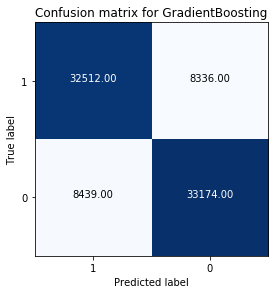

In [29]:

import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(matrix, title, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)


plot_confusion_matrix(array, 'Confusion matrix for GradientBoosting', [1,0])

plt.show()


### Error Analysis

In [34]:
# Split data into 0.8 train and 0.2 test

np.random.seed(seed=13579)

train_idx = np.random.choice(range(len(df_b2_ri_n)), int(len(df_b2_ri_n) * .8), replace=False)
test_idx = list(set(range(len(df_b2_ri_n))) - set(list(train_idx)))

train_x = df_b2_ri_n.loc[train_idx, new_feature_names]
train_y = df_b2_ri_n.loc[train_idx, label_name]
test_x = df_b2_ri_n.loc[test_idx, new_feature_names]
test_y = df_b2_ri_n.loc[test_idx, label_name]

logit = LogisticRegression()
logit.fit(train_x, train_y)

tree = DecisionTreeClassifier(random_state=13579, max_depth=18)
tree.fit(train_x, train_y)

lasso = LogisticRegression(penalty = 'l1')
lasso.fit(train_x, train_y)

knn = KNeighborsClassifier()
knn.fit(train_x, train_y)

forest = RandomForestClassifier(random_state=13579, max_depth=18)
forest.fit(train_x, train_y)

tron = MLPClassifier(random_state=13579)
tron.fit(train_x, train_y)

boost = GradientBoostingClassifier(random_state=13579, max_depth=7)
boost.fit(train_x, train_y)

train_x.head()


,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,total_edits,...,change_in_talk_edits_v2_7_30,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3
56381,-0.059427,-0.089117,-0.176362,0.006731,0.003753,0.068262,-0.087877,0.289132,-0.159826,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
63953,-0.060666,-0.092819,-0.176793,0.007193,0.001692,0.071395,-0.022654,-0.034396,-0.051507,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
63294,-0.058863,-0.084729,-0.171429,0.003349,0.015608,0.058864,-0.170979,0.936189,-0.147791,-0.120863,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
30181,-0.059465,-0.085118,-0.174781,0.006269,-0.000370,0.074527,-0.084211,-0.196160,0.165131,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
64979,-0.054868,-0.068135,-0.151701,0.011268,0.009423,0.061997,0.035115,0.025517,-0.078587,-0.120863,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101


In [35]:
d_test = {'logit': logit.predict(test_x) == test_y, 
          'tree': tree.predict(test_x) == test_y,
          'lasso': lasso.predict(test_x) == test_y,
          'knn': knn.predict(test_x) == test_y,
          'forest': forest.predict(test_x) == test_y,
          'tron': tron.predict(test_x) == test_y,
          'boost': boost.predict(test_x) == test_y}

df_test = pd.DataFrame(data=d_test)
df_test.head()

,boost,forest,knn,lasso,logit,tree,tron
0,True,True,True,True,True,False,True
65538,True,False,True,False,False,False,True
32772,False,False,True,False,False,False,False
32773,True,True,False,True,True,True,False
32776,False,False,False,False,False,False,False


#### Compare true negatives to false positives (i.e. true negatives misclassified) and true positives to false negatives.

Why weren't false positives classified as negatives (which they really are) and false negatives - as positives? As our analysis suggests, "falses" did not provide a clear signal vie features to the classifiers. We compared tn-fp and tp-fp along a few significant features (average and the latest size of the article, totla views and change in views in the latest 3 days) and found that misclassified articles indeed are dissimilar to a class the actually belong to. 

In [ ]:
type(df_test)

df_test[2:9]

misclassified = df_test.loc[(df_test['boost'] == False) & 
            (df_test['forest'] == False) &
            (df_test['knn'] == False) & 
            (df_test['lasso'] == False) &
            (df_test['logit'] == False) & 
            (df_test['tree'] == False) &
            (df_test['tron'] == False)
           ] 

classified_correctly = df_test.loc[(df_test['boost'] == True) & 
            (df_test['forest'] == True) &
            (df_test['knn'] == True) & 
            (df_test['lasso'] == True) &
            (df_test['logit'] == True) & 
            (df_test['tree'] == True) &
            (df_test['tron'] == True)
           ] 

df_false_true = df_b2_reset_index[['article_name','num_edits_binary'] 
                    + new_feature_names].copy(deep=True)


df_false = df_false_true.loc[misclassified.index.tolist(),:]

df_true = df_false_true.loc[classified_correctly.index.tolist()]

#### TN vs. FP:

In [135]:
t_grouped = df_true.groupby('num_edits_binary')
t_grouped.get_group(0).describe()

,num_edits_binary,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,...,change_in_talk_edits_v2_7_30,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3
count,3334.0,3.334000e+03,3.334000e+03,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,...,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000
mean,0.0,9.783887e+04,7.695711e+04,873.574085,-0.867397,0.671641,-5.863227,0.950109,1.020436,1.192736,...,1.000866,0.998993,0.999700,0.003899,-0.000055,0.000225,-0.000300,0.999956,1.000240,0.999800
std,0.0,4.236654e+05,2.718318e+05,3613.856107,50.884138,87.876347,75.534763,0.333673,0.407578,0.762503,...,0.031489,0.024784,0.009996,0.086519,0.005588,0.012989,0.012244,0.005335,0.012726,0.008163
min,0.0,2.276667e+03,0.000000e+00,1.000000,-1714.434783,-893.750000,-2774.000000,0.045078,0.115152,0.090909,...,0.500000,0.571429,0.666667,0.000000,-0.173913,-0.250000,-0.500000,0.851852,0.800000,0.666667
25%,0.0,2.135171e+04,1.580000e+04,50.000000,-1.855978,-1.750000,-2.000000,0.787320,0.800000,0.800000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,0.0,4.129997e+04,3.318600e+04,191.000000,-0.195652,0.000000,0.000000,0.951929,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,0.0,7.890106e+04,6.747775e+04,580.000000,0.402174,1.000000,2.000000,1.064815,1.130017,1.333333,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,0.0,1.865514e+07,8.608046e+06,103695.000000,1011.108696,3958.000000,169.500000,6.681713,8.166667,13.142857,...,1.750000,1.500000,1.000000,4.000000,0.250000,0.500000,0.000000,1.250000,1.500000,1.000000


In [136]:
f_grouped = df_false.groupby('num_edits_binary')
f_grouped.get_group(1).describe()

,num_edits_binary,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,...,change_in_talk_edits_v2_7_30,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3
count,445.0,4.450000e+02,4.450000e+02,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,...,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,1.0,5.678164e+05,4.518613e+05,6894.339326,-11.101295,49.129775,-81.868539,1.294220,2.165260,1.635781,...,1.009745,1.005961,1.009706,0.065169,0.002174,-0.000562,-0.001124,1.001968,0.999850,1.000899
std,0.0,2.886439e+06,1.958317e+06,20255.258743,452.920405,985.551182,895.543458,3.379491,17.659423,5.282159,...,0.135788,0.146691,0.154370,0.575612,0.027919,0.070189,0.085549,0.025586,0.054156,0.055338
min,1.0,3.900000e+03,0.000000e+00,1.000000,-8180.847826,-1209.750000,-18121.500000,0.031060,0.084211,0.080000,...,0.766667,0.363636,0.200000,0.000000,-0.086957,-0.500000,-1.500000,0.920000,0.666667,0.400000
25%,1.0,2.275086e+04,1.467700e+04,129.000000,-5.326087,-4.500000,-24.000000,0.734824,0.775701,0.636364,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.0,4.598950e+04,3.650600e+04,560.000000,-0.663043,-0.250000,-1.500000,0.918733,0.969697,0.857143,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,1.0,2.150339e+05,1.391540e+05,3361.000000,2.413043,2.750000,1.500000,1.111667,1.159021,1.200000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.0,5.492362e+07,2.952560e+07,198322.000000,1651.423913,20101.250000,1438.000000,53.750000,366.400000,65.000000,...,2.967742,3.500000,3.000000,8.000000,0.369565,1.250000,1.000000,1.326923,2.000000,2.000000



*A few major features for false positive class are misleadingly high and distinguish this class from true negatives. In the false positives, median values for avg_size, latest_size, and total_views are higher than those typical for true negative class (45989 > 41299, 36506 > 33186, and 560 > 191), median change in views for the last 3 days is smaller, negative 1.5 vs. 0 for true negative.*



#### TP vs. FN:

In [137]:
t_grouped.get_group(1).describe()

,num_edits_binary,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,...,change_in_talk_edits_v2_7_30,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3
count,3244.0,3.244000e+03,3.244000e+03,3.244000e+03,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000,...,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000
mean,1.0,9.477710e+05,4.186142e+05,6.801099e+03,-27.060583,5.132784,-41.127620,1.162267,1.272797,1.625413,...,1.000992,1.023926,1.001506,0.065043,-0.000141,0.000000,0.001695,1.000043,1.000382,1.001675
std,0.0,1.563197e+07,2.919880e+06,3.506887e+04,1052.861645,705.898158,375.808891,4.340640,3.681844,9.677720,...,0.079047,0.885710,0.102233,0.440501,0.029124,0.045198,0.072913,0.027687,0.041682,0.055963
min,1.0,0.000000e+00,0.000000e+00,1.000000e+00,-34593.315217,-23670.500000,-14335.500000,0.018584,0.031228,0.033333,...,0.177469,0.400000,0.125000,0.000000,-0.478261,-0.750000,-1.000000,0.676471,0.571429,0.500000
25%,1.0,2.237215e+04,1.599800e+04,1.207500e+02,-5.144022,-4.500000,-14.500000,0.737786,0.771041,0.666667,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.0,4.396932e+04,3.292500e+04,4.800000e+02,-0.804348,-0.500000,-1.000000,0.919336,0.960737,0.897933,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,1.0,1.585443e+05,1.189960e+05,2.946000e+03,1.163043,2.000000,1.500000,1.078125,1.153846,1.230769,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.0,8.386838e+08,1.303305e+08,1.080787e+06,23720.673913,21298.250000,3700.000000,210.500000,108.500000,428.400000,...,3.114583,50.000000,3.000000,11.000000,0.750000,1.500000,2.500000,1.750000,2.500000,2.666667


In [138]:
f_grouped.get_group(0).describe()

,num_edits_binary,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,...,change_in_talk_edits_v2_7_30,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3
count,443.0,4.430000e+02,4.430000e+02,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,...,443.000000,443.000000,443.0,443.000000,443.000000,443.0,443.0,443.000000,443.0,443.0
mean,0.0,1.273558e+05,8.080245e+04,1339.106095,-3.196413,-2.199210,-9.704289,0.958183,1.058205,1.308931,...,0.999699,0.999248,1.0,0.004515,-0.000196,0.0,0.0,0.999819,1.0,1.0
std,0.0,1.029861e+06,4.577211e+05,12164.005921,89.387914,53.041121,128.253256,0.329142,0.581002,3.198801,...,0.020772,0.015837,0.0,0.095023,0.004131,0.0,0.0,0.003801,0.0,0.0
min,0.0,4.675000e+03,4.675000e+03,1.000000,-1771.706522,-1007.750000,-2507.500000,0.185484,0.177778,0.231738,...,0.851852,0.666667,1.0,0.000000,-0.086957,0.0,0.0,0.920000,1.0,1.0
25%,0.0,1.973599e+04,1.423350e+04,50.000000,-2.032609,-1.625000,-2.500000,0.773134,0.800000,0.800000,...,1.000000,1.000000,1.0,0.000000,0.000000,0.0,0.0,1.000000,1.0,1.0
50%,0.0,4.226187e+04,3.301900e+04,214.000000,-0.184783,0.000000,0.000000,0.953209,1.000000,1.000000,...,1.000000,1.000000,1.0,0.000000,0.000000,0.0,0.0,1.000000,1.0,1.0
75%,0.0,7.891165e+04,6.305600e+04,651.500000,0.543478,1.250000,2.000000,1.069170,1.131870,1.250000,...,1.000000,1.000000,1.0,0.000000,0.000000,0.0,0.0,1.000000,1.0,1.0
max,0.0,2.131399e+07,9.323321e+06,251076.000000,543.021739,237.250000,295.500000,3.234375,9.232558,66.666667,...,1.380000,1.000000,1.0,2.000000,0.000000,0.0,0.0,1.000000,1.0,1.0


*In the false negatives, median values for avg_size and total_views are lower than those typical for true negative class (42261 < 43969 and 214 < 480), while the latest_size is comparable (33019 > 32925). Median change in views for the last 3 days is also similar to true positive, namely 0.*

#### And how much overlap in misclassification does exist among the classifiers?

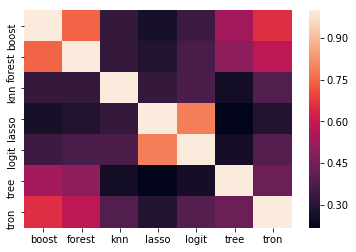

In [36]:
import seaborn as sns

corr = df_test.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

**From the heatmap above we can see that RandomForest and GradientBoosting misclassify approximately the same datapoints (around 75% overlap), while LASSO and DecisionTree have less than 30% overlap among their false.**

### Feature importances

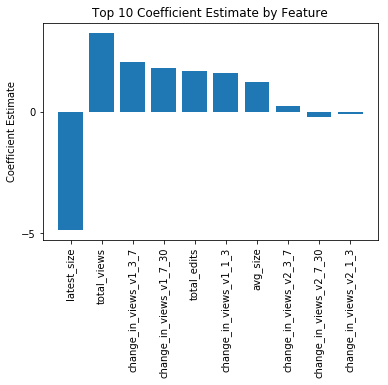

In [147]:
# Logistic regression

logit = LogisticRegression()
logit.fit(train_x, train_y)

logit_coefficients = logit.coef_

plot_lim = 10
ax = plt.gca()
_, sort_i = list(zip(*sorted(zip(np.abs(logit_coefficients[0]), range(plot_lim)), reverse=True)))
coefs = [logit_coefficients[0][i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]
plt.bar(range(plot_lim), coefs, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Coefficient Estimate')
ax.set_title('Top 10 Coefficient Estimate by Feature')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 30})

plt.show()

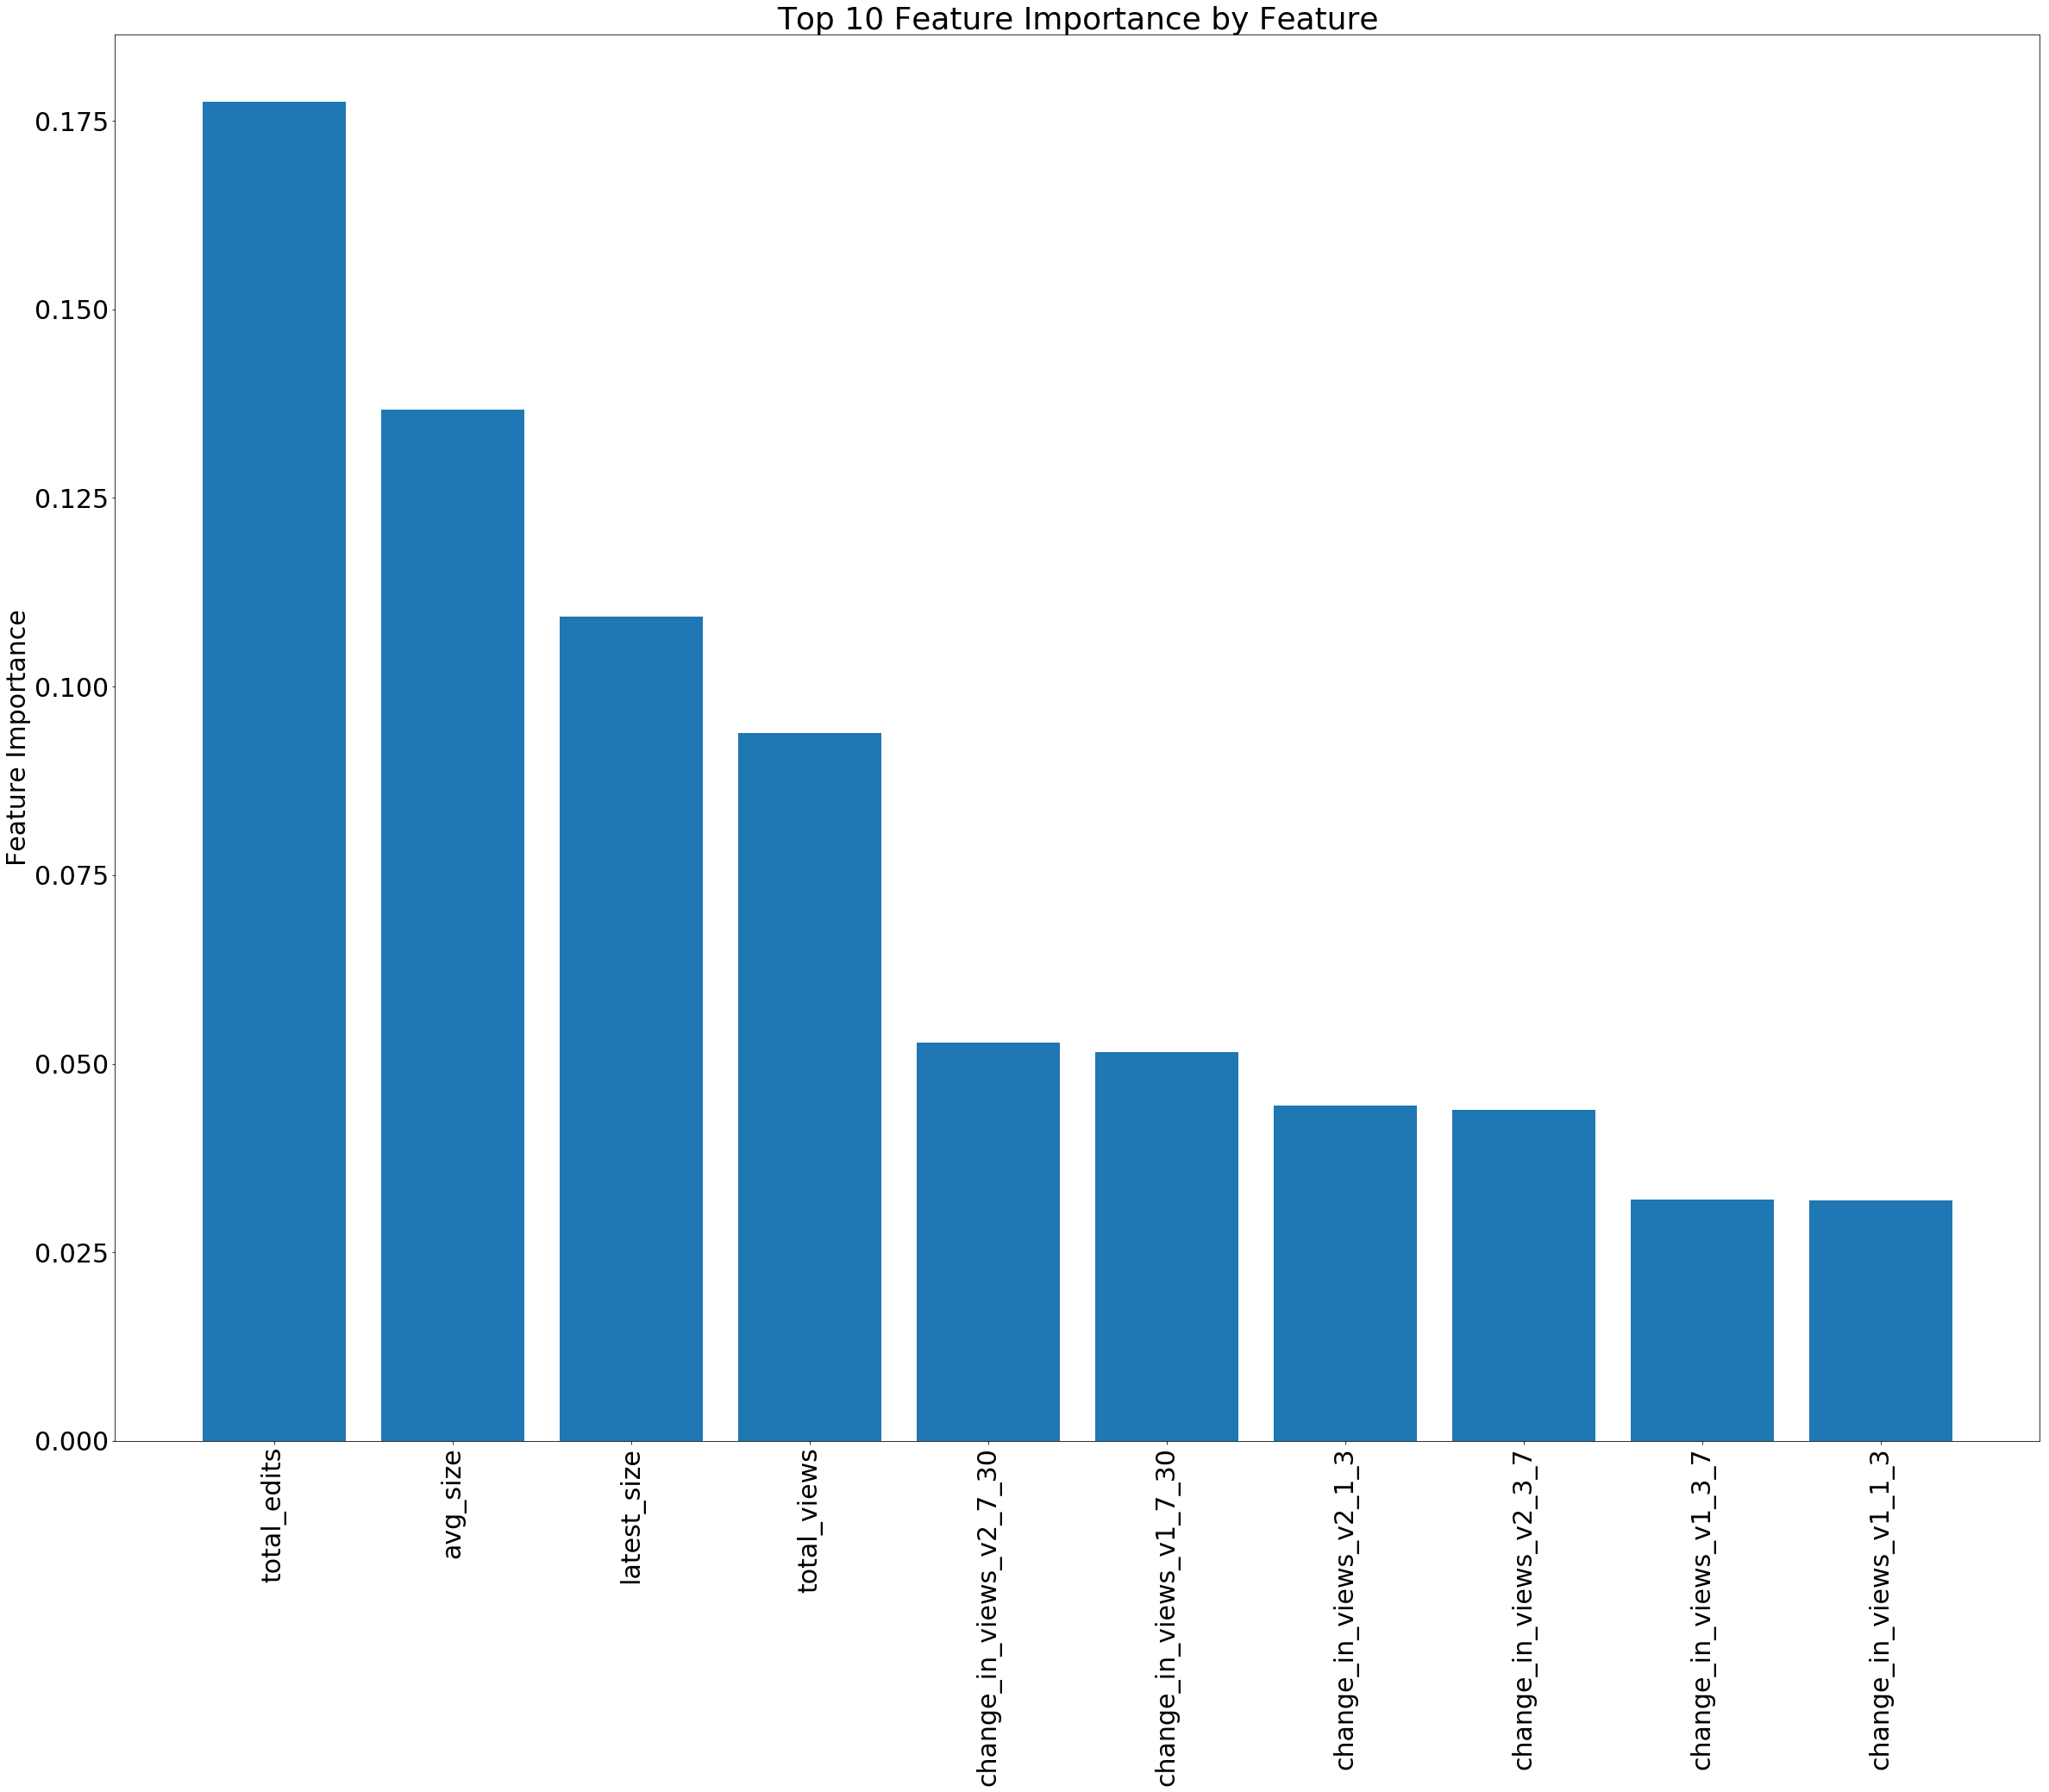

In [149]:
# Decision tree

tree = DecisionTreeClassifier(random_state=13579)
tree.fit(train_x, train_y)

feature_importances = tree.feature_importances_

ax = plt.gca()
_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]
plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size


plt.show()

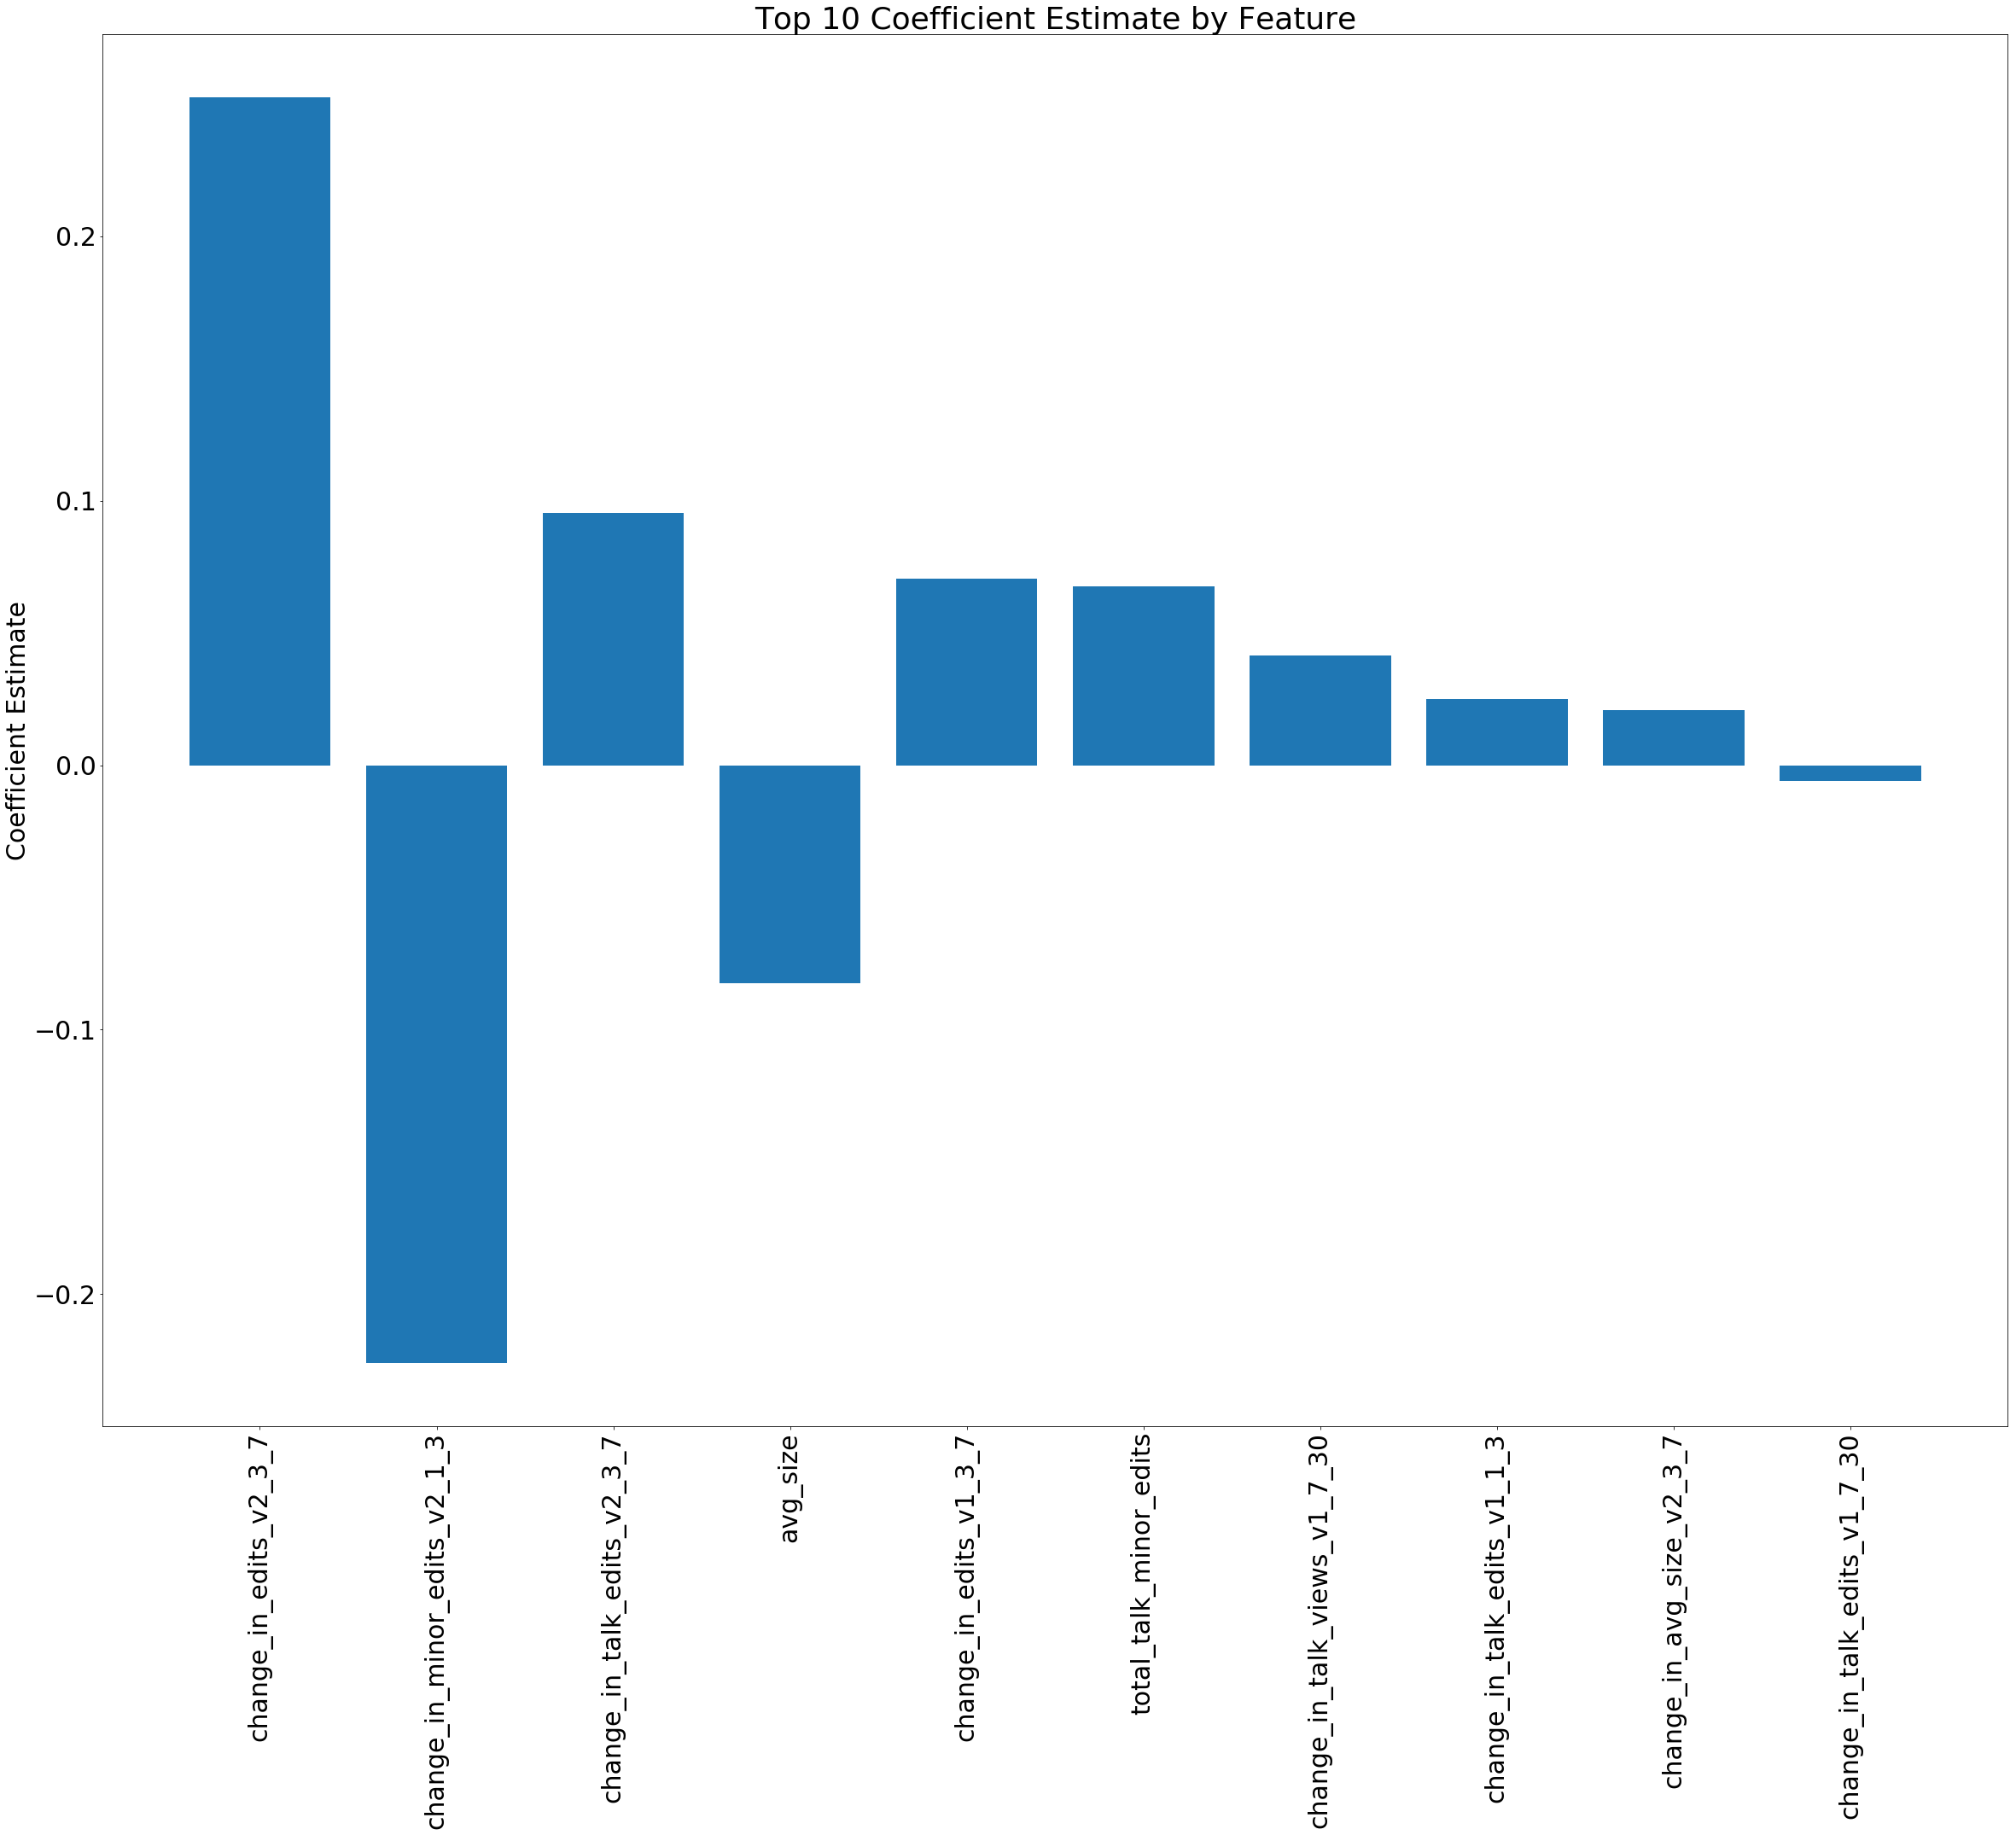

In [61]:
# LASSO

lasso = LogisticRegression(penalty = 'l1')
lasso.fit(train_x, train_y)

lasso_coefficients = lasso.coef_

ax = plt.gca()
_, sort_i = list(zip(*sorted(zip(np.abs(lasso_coefficients[0]), range(plot_lim)), reverse=True)))
sorted_coefs = [lasso_coefficients[0][i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

plt.bar(range(plot_lim), sorted_coefs, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Coefficient Estimate')
ax.set_title('Top 10 Coefficient Estimate by Feature')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [ ]:
# K-nearest neighbors (TAKES FOREVER TO RUN, IGNORE FOR NOW)
# TODO: Update to grab just top 10 features.

np.random.seed(seed=13579)

knn = KNeighborsClassifier()

knn_features = features
knn_target = 'num_edits_binary'

old_vars = []

final_lst = []

while len(knn_features) > 0:
    one_run = []
    for feature in knn_features:
        one_run += [[np.mean(cross_val_score(knn, 
                                             df_b2_ri_n[old_vars + [feature]], 
                                             df_b2_ri_n[target], 
                                             cv=2)), 
                     feature]]
    one_run.sort(key = lambda x: x[0], reverse=True)
    final_lst += [one_run[0]]
    old_vars += [one_run[0][1]]
    knn_features = [f for f in knn_features if f != one_run[0][1]]
    if len(final_lst) >= 2 and final_lst[-1][0] < final_lst[-2][0]:
        final_lst = final_lst[:-1]
        break

plt.plot([i for i in range(len(final_lst))],
            [final_lst[i][0] for i in range(len(final_lst))], "-o")

labels = [final_lst[i][1] for i in range(len(final_lst))]

plt.xticks([i for i in range(len(final_lst))], 
           labels, rotation='vertical')

plt.ylabel("Accuracy")
plt.title("Forward Selection")

plt.show()

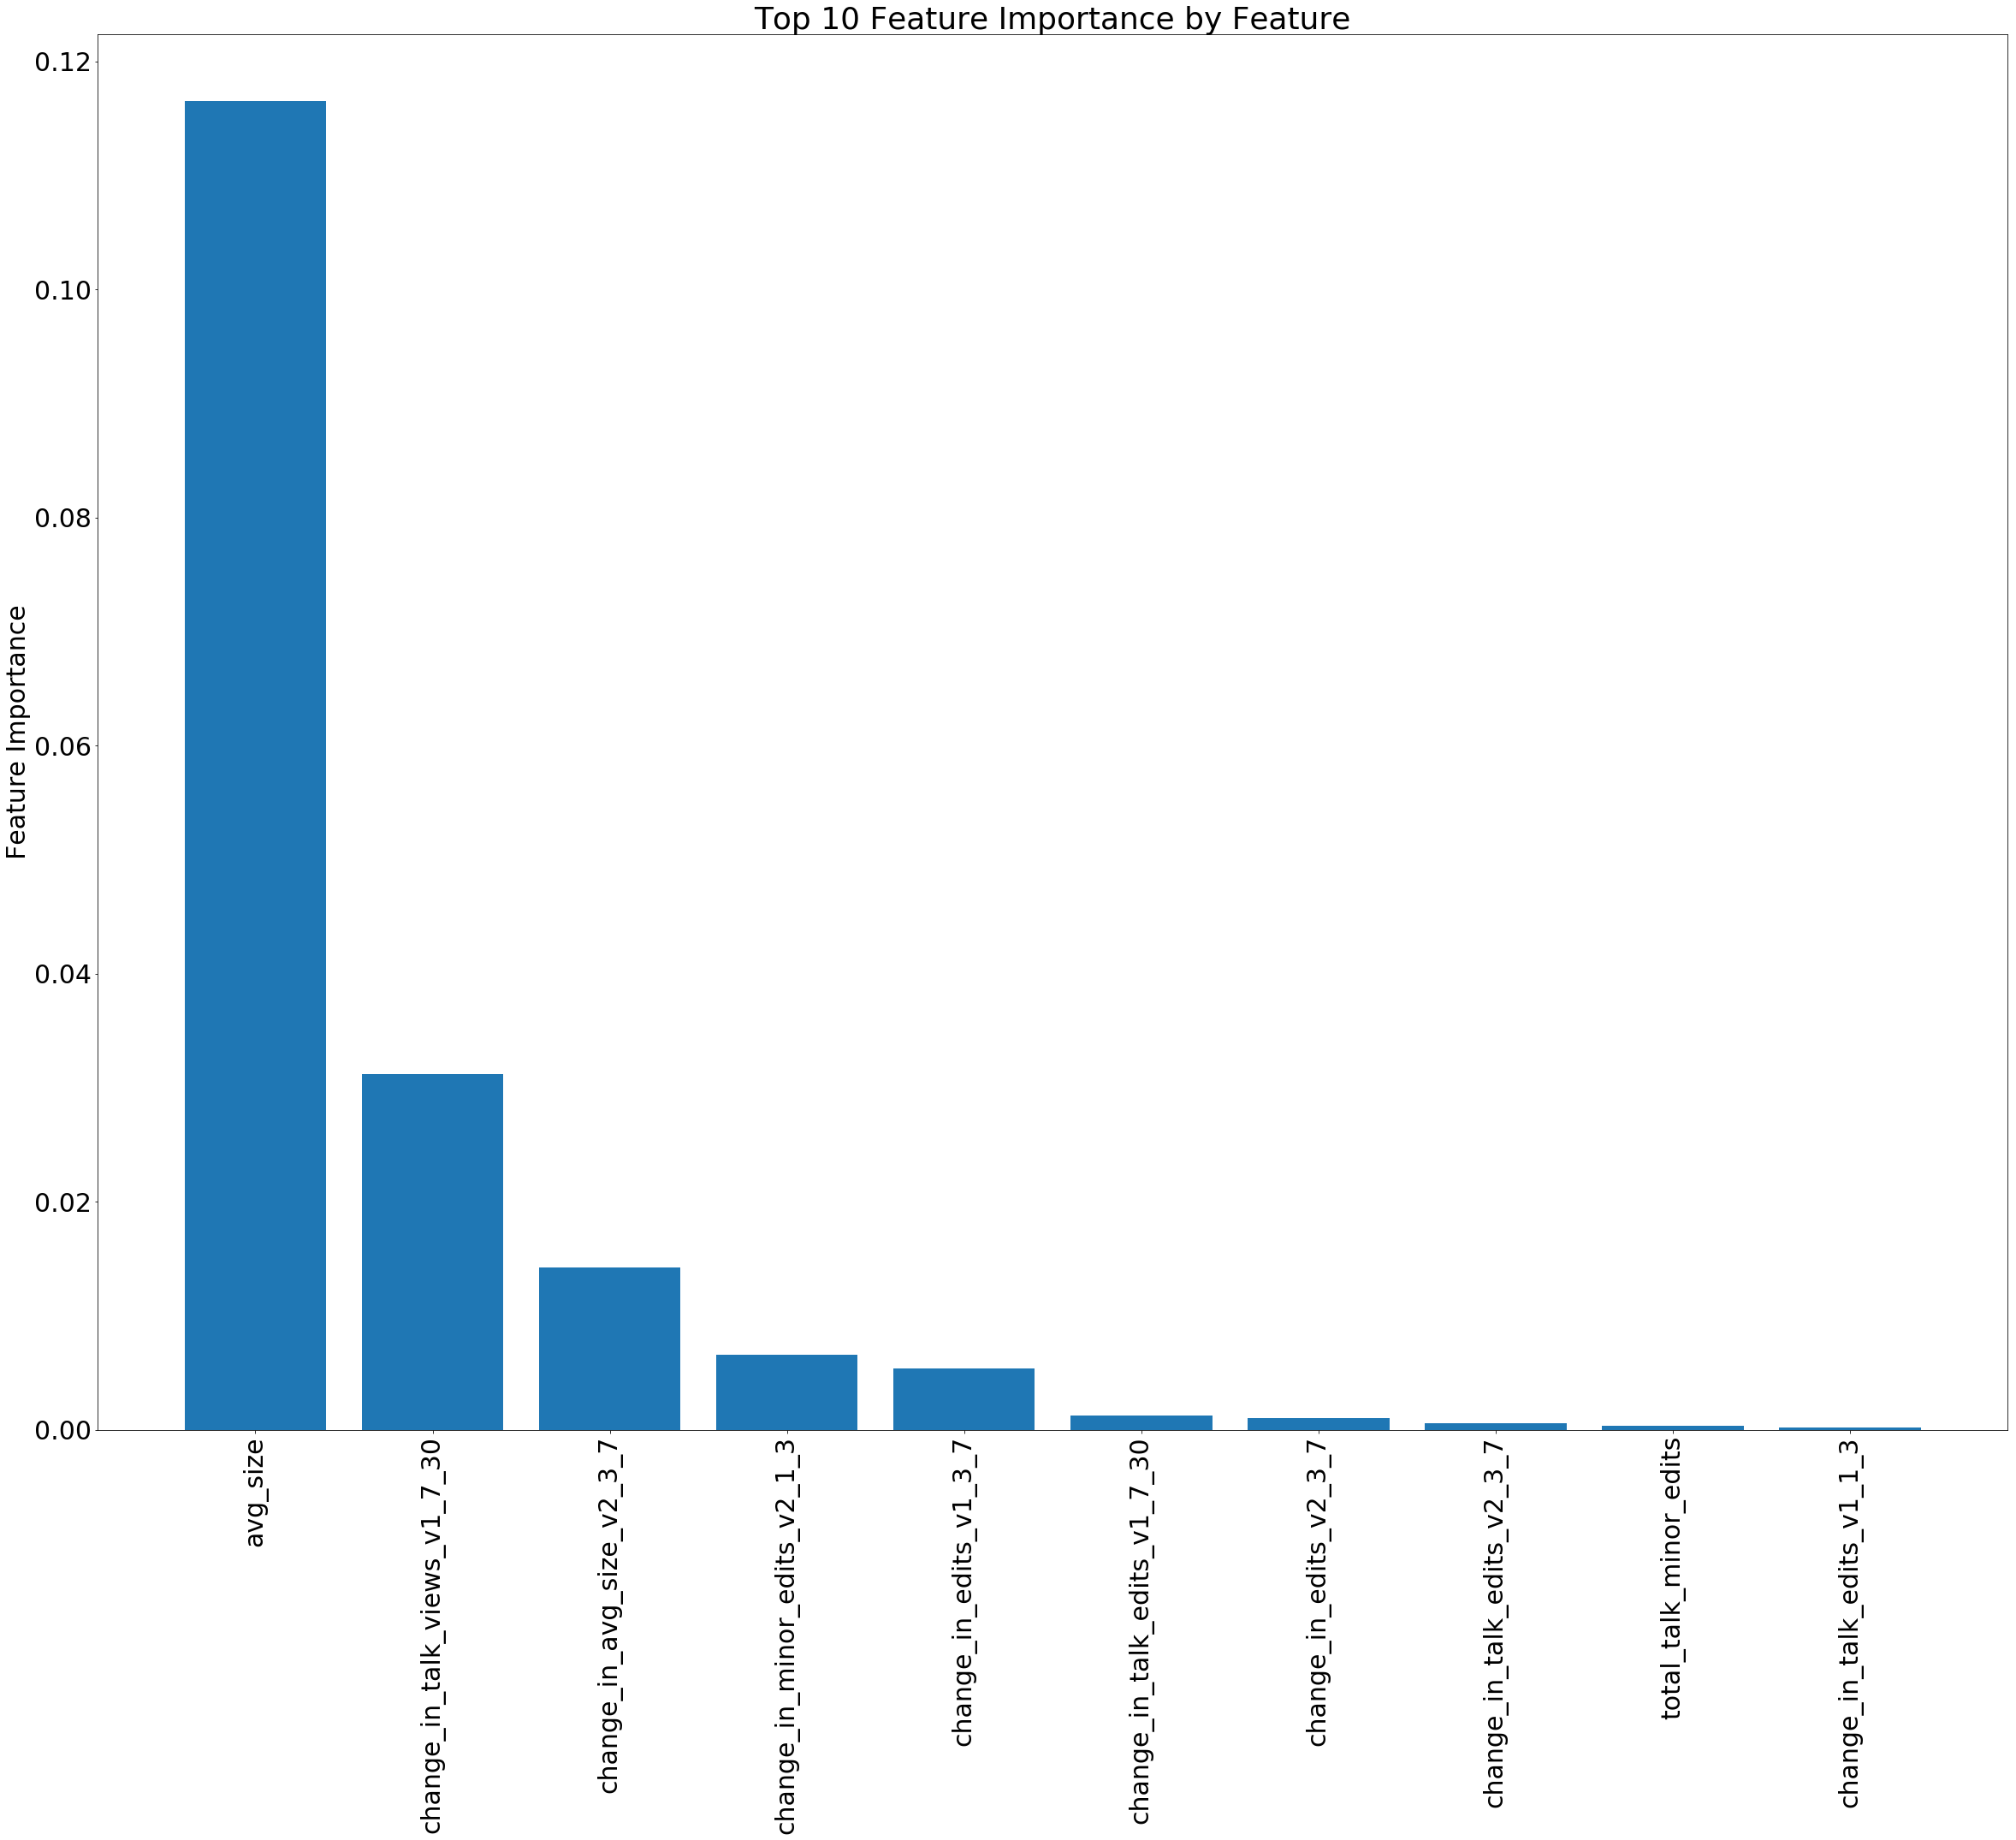

In [62]:
# Random forest

forest = RandomForestClassifier(random_state=13579)
forest.fit(train_x, train_y)

feature_importances = forest.feature_importances_
_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

ax = plt.gca()
plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [ ]:
# Multi-layer perceptron (TAKES FOREVER TO RUN, IGNORE FOR NOW)
# TODO: Update to grab just top 10 features.

tron_features = features
tron_target = 'num_edits_binary'

final_lst = []

while len(tron_features) > 1:
    one_run = []
    for feature in tron_features:
        tron = MLPClassifier(solver='lbfgs', random_state=13579)
        one_run += [[np.mean(cross_val_score(tron, 
                                             df_b2_ri_n[list(set(tron_features) - set([feature]))], 
                                             df_b2_ri_n[tron_target], 
                                             cv=2)), 
                     feature]]
    one_run.sort(key = lambda x: x[0])
    final_lst += [one_run[0]]
    tron_features = [f for f in tron_features if f != one_run[0][1]]
    print(tron_features)

plt.plot([i for i in range(len(final_lst))],
            [final_lst[i][0] for i in range(len(final_lst))], "-o")

labels = [final_lst[i][1] for i in range(len(final_lst))]

plt.xticks([i for i in range(len(final_lst))], 
           labels, rotation='vertical')

plt.ylabel("Accuracy")
plt.title("Backward Selection")

plt.show()

In [ ]:
# Gradient boosting

boost = GradientBoostingClassifier(random_state=13579)
boost.fit(train_x, train_y)

feature_importances = boost.feature_importances_
_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

ax = plt.gca()
plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

plt.show()

**Analisys**
* It seems like for different models, different features are more important. Very often, it is total_views, total_talk_views, total_edits, as well as avg_size and latest_size (but not for lasso and logistic regression). 

* We can try some dimensionality reduction technique, like principal component analysis (PCA) to see if it is possible to cut on the number of features without damage to explained variance.

In [167]:
from sklearn.decomposition import PCA

#we'll use Minka’s MLE to guess the dimensions

pca = PCA(n_components='mle', svd_solver='full')
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [175]:
print("initial number of features: ", len(new_feature_names))

initial number of features:  50


In [176]:
print("after dimensionality resuction: ", pca.n_components_)

after dimensionality resuction:  49


The PCA results suggest that ~50 is the reasonable number of features for this data set. This is an expected result, since our data is not very sparse (sparsity is one use case for PCA), and 50 dimensions is not too much (high dimensionality - another use case). 

In [ ]:
# TBD LATER IF HAVE EXTRA TIME

# - Explore class weights
# - Explore different algorithms